# Usage Notes for: Dataset of human skin and fingernails images for non-invasive haemoglobin level assessment

## Modules installation and initialization

In [1]:
#uncomment next line to install prerequisite python modules
#!pip install -r requirements.txt

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import matplotlib.patches as mpatches

import os
import json
import scipy.stats as stats
from collections import defaultdict
import tqdm

import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline 
import sklearn.linear_model

import warnings
warnings.filterwarnings(action='ignore',category=sklearn.exceptions.ConvergenceWarning)

## Metadata loading and hand pictures evaluation

First, we will read the data and make sure that the table is recognized correctly.

In [3]:
metadata = pd.read_csv('data/metadata.csv')

In [4]:
metadata.shape

(250, 5)

In [5]:
metadata.head()

,PATIENT_ID,MEASUREMENT_DATE,HB_LEVEL_GperL,NAIL_BOUNDING_BOXES,SKIN_BOUNDING_BOXES
0,1,14b0293a34344cc4fba0fa39d5370c52,134.0,"[[251, 447, 302, 505], [123, 429, 183, 483], [...","[[267, 586, 324, 627], [148, 556, 200, 614], [..."
1,2,14b0293a34344cc4fba0fa39d5370c52,108.0,"[[236, 503, 281, 556], [148, 457, 195, 514], [...","[[252, 612, 294, 647], [162, 585, 212, 632], [..."
2,5,14b0293a34344cc4fba0fa39d5370c52,84.0,"[[244, 508, 277, 562], [183, 448, 220, 505], [...","[[264, 629, 303, 662], [193, 584, 232, 619], [..."
3,6,14b0293a34344cc4fba0fa39d5370c52,138.0,"[[311, 456, 363, 521], [182, 408, 237, 471], [...","[[318, 609, 380, 650], [189, 562, 245, 616], [..."
4,7,14b0293a34344cc4fba0fa39d5370c52,119.0,"[[29, 513, 78, 556], [119, 435, 165, 479], [18...","[[29, 635, 79, 678], [117, 564, 175, 615], [20..."


When the `metadata.csv` file is loaded, the lists of `NAIL_BOUNDING_BOXES` and `SKIN_BOUNDING_BOXES` for each patient are read as strings, we will convert them back to lists of lists.

In [6]:
metadata['NAIL_BOUNDING_BOXES'] = metadata['NAIL_BOUNDING_BOXES'].apply(json.loads)
metadata['SKIN_BOUNDING_BOXES'] = metadata['SKIN_BOUNDING_BOXES'].apply(json.loads)

Now we will display raw images of patients' hands and corresponding bounding boxes for fingernails (red rectangles) and skin regions (blue rectangles). We also segment the region with the white background to normalize the intensities of the RGB images of the nails and skin to assure independency of the image intensities on the illumination (green rectangle). 

- `N_MAX_IMAGES` variable controls the number of images to display. 
- raw images are supposed to be stored at `data/photo/` directory.

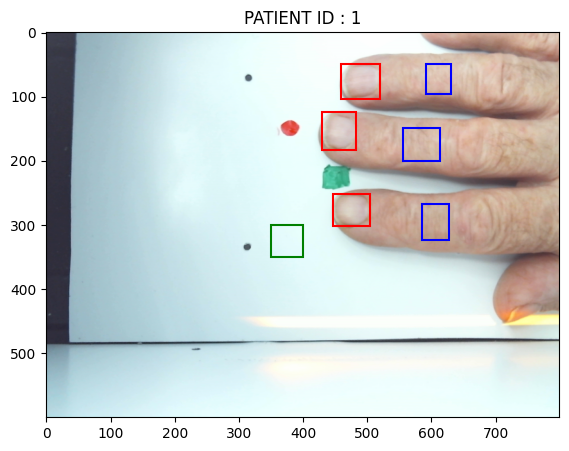

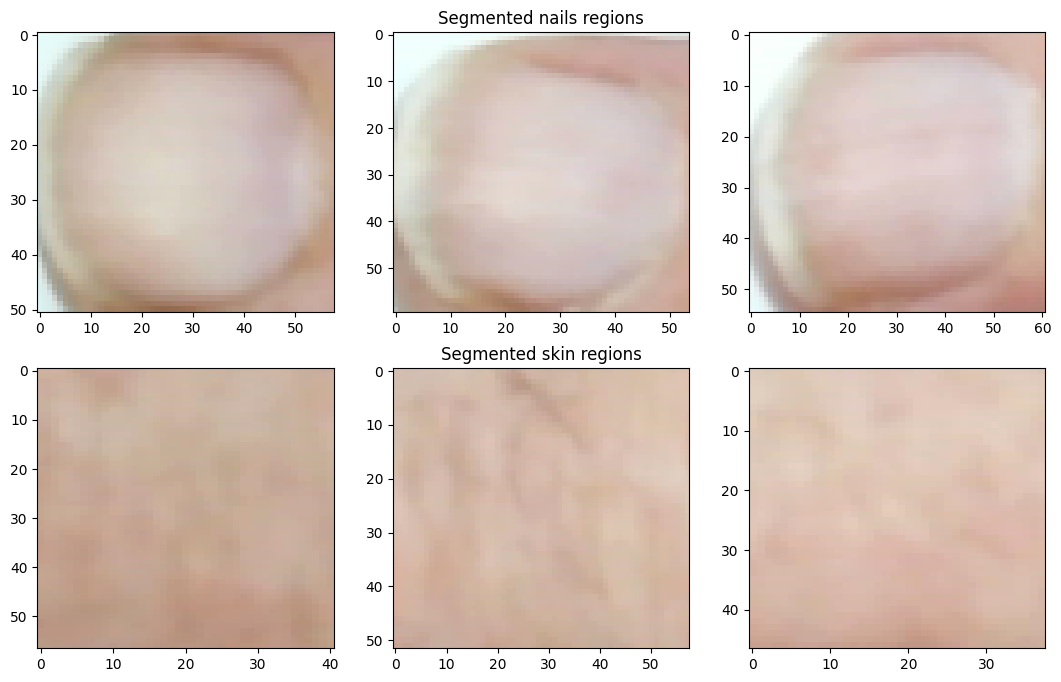

In [7]:
image_folder = 'data/photo/'
N_MAX_IMAGES = 1

for j,(_, row) in enumerate(metadata.iterrows()):
    
    if j ==  N_MAX_IMAGES:
        break
    
    img_path = os.path.join(image_folder,f'{row.PATIENT_ID}.jpg')
    
    img = skio.imread(img_path)
    
    plt.figure(figsize=(7,5))
    plt.imshow(img)
    
    nails_bboxes = row.NAIL_BOUNDING_BOXES
    skin_bboxes  = row.SKIN_BOUNDING_BOXES
    
    ax = plt.gca()
    
    for _color,_bboxes in zip(['r','b'],[nails_bboxes,skin_bboxes]):
        for top,left,bot,right in _bboxes:
            
            w,h = right-left,bot-top
            
            rectangle = mpatches.Rectangle(xy=(left,top),width=w,height=h,fill=None,
                                           color=_color,linewidth=1.5)
            
            ax.add_patch(rectangle)
            
    white_region_rectangle = mpatches.Rectangle(xy=(350,300),width=50,height=50,fill=None,
                                           color='green',linewidth=1.5)
    ax.add_patch(white_region_rectangle)
    
    plt.title(f"PATIENT ID : {row.PATIENT_ID}")
    
    fig,axs = plt.subplots(2,3,figsize=(13,8))
    axs = axs.ravel()
    
    all_bboxes = nails_bboxes + skin_bboxes
    
    for i,(top,left,bot,right) in enumerate(all_bboxes):
        axs[i].imshow(img[top:bot,left:right],aspect='auto')
        if i == 1:
            axs[i].set_title("Segmented nails regions")
        if i == 4:
            axs[i].set_title("Segmented skin regions")
        
    plt.show()

## Features extraction for simple ML model for blood haemoglobin level prediction

To predict the haemoglobin level, we used the values of the percentiles of the intensity distribution of the segmented areas of the nails and skin of patients.

As segmented image crops of fingernails could partially include areas that did not correspond to nail plates, central areas of the cropped nails and skin regions of the 60% (`cut_image` function)  width and height of initial crop were selected. For the selected inner regions the values of the 5-, 15-, 25-, 50-, 75-, 85- and 95- percentile levels of the intensity distribution for the R,G and B channels were calculated (42 features in total, `calculate_features` function). 

For simplicity, we only used information from the middle finger for all patients. 

Obviously, additional verification of the model and increase in accuracy can achieved by using the information from several fingers by averaging the prediction results or using other aggregation methods. The obtained intensity values were then normalized to the median of RGB intensities of the white background region. The resulting 42 descriptors for all 250 patients were used as input features for training machine learning algorithms to predict the Hb level.

In [8]:
def cut_image(img,low=0.2,high=0.8):
    h,w = img.shape[:2]
    return img[int(low*h):int(high*h),int(low*w):int(high*w),:]

def calculate_features(img,percentile_levels=[5,15,25,50,75,85,95],low=0.2,high=0.8):
    features_dict = {}
    for color_chan_id,color in enumerate('RGB'):
        for percentile_level in percentile_levels:
            
            cutted_image = cut_image(img,low=low,high=high)
            feature_value = np.percentile(cutted_image[:,:,color_chan_id].ravel(),percentile_level)
            feature_name = f'{color}_p={percentile_level}'
            
            features_dict[feature_name] = feature_value
    return features_dict

In [9]:
images = defaultdict(list)

for j,(_, row) in tqdm.tqdm(enumerate(metadata.iterrows())):
    
    img_path = os.path.join(image_folder,f'{row.PATIENT_ID}.jpg')
    
    img = skio.imread(img_path)
    
    nails_bboxes = row.NAIL_BOUNDING_BOXES
    skin_bboxes  = row.SKIN_BOUNDING_BOXES
    
    for _tissue_site,_bboxes in zip(['NAIL','SKIN'],[nails_bboxes,skin_bboxes]):
        for finger_num,(top,left,bot,right) in enumerate(_bboxes,start=1):
            
            key = f'{_tissue_site}_{finger_num}'
            images[key].append(img[top:bot,left:right])
            
    images['WHITE_REF'].append(img[350:400,300:350])

250it [00:02, 118.34it/s]


In [10]:
white_ref_median = pd.DataFrame({f'{color}':[np.median(img[:,:,color_chan_id].ravel()) for img in images['WHITE_REF']] 
                          for color_chan_id,color in enumerate("RGB")})

nail_features = pd.DataFrame([calculate_features(img) for img in images['NAIL_2']]).rename(columns=lambda x: f'NAIL_{x}')
skin_features = pd.DataFrame([calculate_features(img) for img in images['SKIN_2']]).rename(columns=lambda x: f'SKIN_{x}')

features = pd.concat([nail_features,skin_features],axis=1)

for feature in features:
    color = feature.split('_')[1]
    features[feature] = features[feature]/white_ref_median[color]

## Balancing dataset

Since for classical machine learning algorithms it is highly desirable that the high and low target values are almost uniformly presented in the training dataset, the data were additionally balanced. 

To balance the sample, the empirical probability density function $p$ of the Hb level was fitted using the kernel density estimation method with Gaussian kernel with bandwidth of 0.5 g/L (`target_kde` variable), and then 100 observations (i.e. patients with known Hb level) were sampled without replacement from the dataset with a probability for each point proportional to $\propto 1/p$ (`weights` variable).

Thus, less presented Hb level values would be sampled with higher probability. The balancing procedure led to the fact that nearly 44% of observations in the balanced dataset fell into the Hb level region of <120 g/L instead of 28% values in the initial dataset.

In [11]:
target = metadata['HB_LEVEL_GperL']

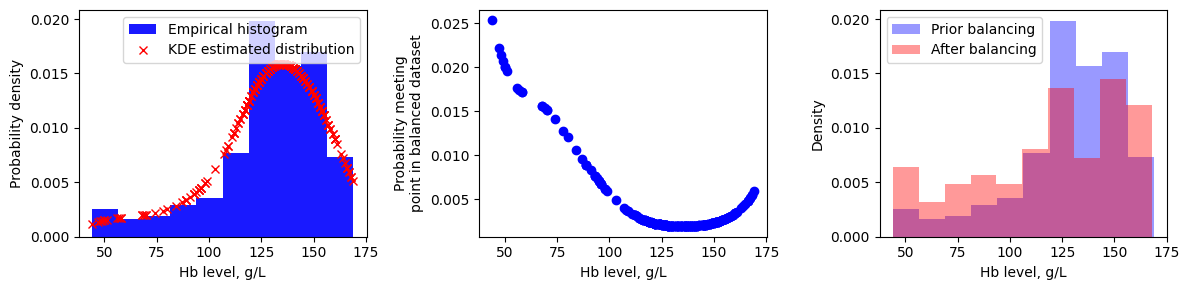

In [12]:
np.random.seed(42)

target_kde = stats.gaussian_kde(target,bw_method=0.5)(target)
weights = 1/target_kde
weights /= np.sum(weights)

patient_ids = metadata['PATIENT_ID']
balanced_patient_ids = np.random.choice(patient_ids,size=100,replace=False,p=weights)
balancing_mask = metadata['PATIENT_ID'].isin(balanced_patient_ids).values

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)

plt.hist(target,density=True,label='Empirical histogram',color='b',alpha=0.9)
plt.plot(target,target_kde,'x',color='r',label='KDE estimated distribution')

plt.legend()
plt.ylabel("Probability density")
plt.xlabel("Hb level, g/L")

plt.subplot(1,3,2)
plt.plot(target,weights,'o',color='b')

plt.ylabel("Probability meeting\npoint in balanced dataset")
plt.xlabel("Hb level, g/L")

plt.subplot(1,3,3)
plt.hist(target,density=True,alpha=0.4,label='Prior balancing',color='b')
plt.hist(target[balancing_mask],density=True,alpha=0.4,label='After balancing',color='r')

plt.xlabel("Hb level, g/L")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()

In [13]:
np.mean(target < 120)

0.276

In [14]:
np.mean(target[balancing_mask] < 120)

0.44

## Initialization of cross-validation scheme, evaluation metrics, input features, target variable and model

The root mean squared error (RMSE) was used to evaluate the model accuracy, while the model validation was performed in a two-step way: the selection of model hyperparameters was carried out using 7-fold cross-validation on a selected balanced subset of 100 patients, and the final model testing was performed on patients not included in the balanced train dataset.

In [15]:
X = features[balancing_mask]
y = target[balancing_mask]

In [16]:
cv_scheme = sklearn.model_selection.KFold(n_splits=7)
scoring = sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,greater_is_better=False,squared=False)

In [17]:
model = sklearn.pipeline.Pipeline(
    steps=[
        ('scaler',sklearn.preprocessing.RobustScaler()),
        ('regressor',sklearn.linear_model.ElasticNet(max_iter=10000))
    ]
)

For demonstration, linear regression was used to predict the Hb level from the extracted features. Since some features were correlated with each other, to eliminate the “redundant description”, we used a modification of linear regression with L1 and L2 regularization (the so-called Elastic Net model), where the ratio between L1 and L2 regularization ($l_1-ratio$) and the contribution of the regularization term to the loss function ($\alpha$) were optimized using exhaustive search over the grid of the hyperparameters. We varied the $l_1-ratio$ on the grid of five values ($l_1-ratio= \{0.01,0.1,0.5,0.9,0.99\}$), while the α parameter varied on the logarithmic grid from $10^{-4}$ to $10^4$ with 50 steps. The best hyperparameters for the Elastic Net model implemented in the Scikit-Learn library37 were found to be equal to $l_1-ratio= 0.9$ and $\alpha \approx 0.2$.

In [18]:
grid_searcher = sklearn.model_selection.GridSearchCV(model,
                                                     param_grid={'regressor__l1_ratio':[0.01,0.1,0.5,0.9,0.99],
                                                                 'regressor__alpha':np.logspace(-4,4,num=100)},
                                                    verbose=1,
                                                    cv=cv_scheme,return_train_score=True,
                                                    scoring=scoring)

In [19]:
grid_searcher.fit(X,y)

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('regressor',
                                        ElasticNet(max_iter=10000))]),
             param_grid={'regressor__alpha': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6...
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                         'regressor__l1_ratio': [0.01, 0.1, 0.5, 0.9, 0.99]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=1)

In [20]:
grid_searcher.best_score_

-23.85579019068387

In [21]:
grid_searcher.best_params_

{'regressor__alpha': 0.20565123083486536, 'regressor__l1_ratio': 0.9}

## Model evaluation on validation and test sets

The results of the best model predictions on the validation and test sets are presented in figures below. It can be seen that the model built on the validation set generalizes well to the test data, but slightly overestimates the values in the range of low Hb levels. The overall model error in terms of RMSE was equal to 24 g/L on the validation data set and 20 g/L on the test data set. The lower error on the test dataset can be explained by the fact that the true values of the Hb level in the test dataset are mainly localized in the normal Hb level range. 

In [22]:
best_model = model.set_params(**grid_searcher.best_params_)

In [23]:
y_pred = sklearn.model_selection.cross_val_predict(best_model,X,y=y,cv=cv_scheme)

In [24]:
best_model.fit(X,y)

Pipeline(steps=[('scaler', RobustScaler()),
                ('regressor',
                 ElasticNet(alpha=0.20565123083486536, l1_ratio=0.9,
                            max_iter=10000))])

In [25]:
test_patients = ~balancing_mask

X_test = features[test_patients]
y_test = target[test_patients]

In [26]:
y_pred_test = best_model.predict(X_test)

In [27]:
val_rmse = sklearn.metrics.mean_squared_error(y,y_pred,squared=False)
test_rmse = sklearn.metrics.mean_squared_error(y_test,y_pred_test,squared=False)

Validation set bias: 0.4 g/L
Validation set (bias - 1.96*SD, bias + 1.96*SD): (-46.6,47.5) g/L)
------
Test set bias: -4.3 g/L
Test set (bias - 1.96*SD, bias + 1.96*SD): (-43.1,34.5) g/L)
------


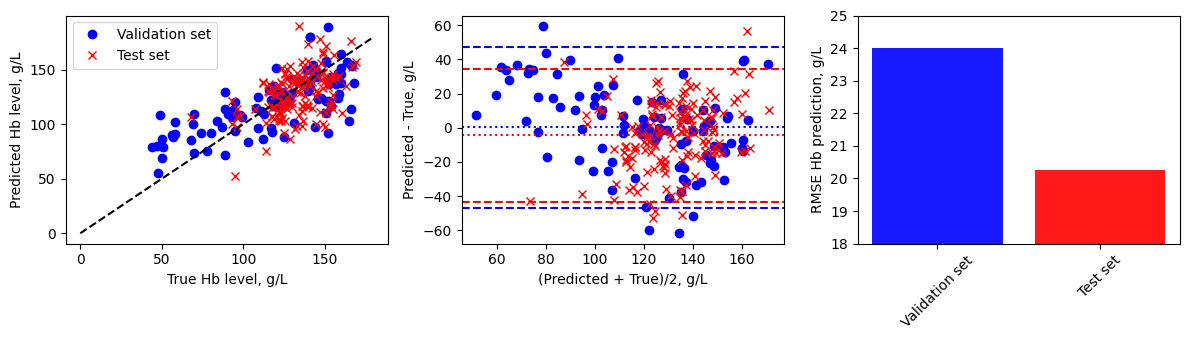

In [28]:

plt.figure(figsize=(12,3.5))
plt.subplot(1,3,1)

plt.plot(y,y_pred,'bo',label='Validation set')
plt.plot(y_test,y_pred_test,'rx',label='Test set')
plt.plot(np.linspace(0,180),np.linspace(0,180),color='k',linestyle='dashed')

plt.legend()
plt.ylabel("Predicted Hb level, g/L")
plt.xlabel("True Hb level, g/L")

plt.subplot(1,3,2)

sets = [[y, y_pred,'Validation set'],
        [y_test,y_pred_test, 'Test set']]

marker_style = {"Validation set":'o','Test set':'x'}
colors = {"Validation set": 'b','Test set':'r'}

for _true,_pred, _set_type in sets:
    
    _avg = (_true + _pred)/2.
    _diff = _pred - _true
    
    _SD = np.std(_diff)
    _bias = np.mean(_diff)
    
    color = colors[_set_type]
    plt.plot(_avg,_diff,color=color,linestyle='None', marker=marker_style[_set_type])
    
    plt.axhline(_bias,linestyle='dotted',color=color)
    
    plt.axhline(_bias + 1.96*_SD,linestyle='dashed',color=color)
    plt.axhline(_bias - 1.96*_SD,linestyle='dashed',color=color)
    
    print(f'{_set_type} bias: {_bias:.1f} g/L')
    print(f'{_set_type} (bias - 1.96*SD, bias + 1.96*SD): ({_bias - 1.96*_SD:.1f},{_bias + 1.96*_SD:.1f}) g/L)')
    
    print('------')
plt.ylabel("Predicted - True, g/L")
plt.xlabel("(Predicted + True)/2, g/L")


plt.subplot(1,3,3)

plt.bar([0,1],[val_rmse,test_rmse],color=['b','r'],alpha=0.9)
plt.xticks([0,1],['Validation set','Test set'],rotation=45)
plt.ylabel("RMSE Hb prediction, g/L")
plt.ylim(18,25)
plt.tight_layout()